# Room Temperature Data - Prophet Model 🌡️

In [295]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [296]:
df = pd.read_csv("MLTempDataset.csv")
df

,Unnamed: 0,Datetime1,DAYTON_MW,Datetime
0,0,0,20.867,2022-01-04 00:00:00
1,1,1,21.000,2022-01-04 01:00:00
2,2,2,20.867,2022-01-04 02:00:00
3,3,3,20.650,2022-01-04 03:00:00
4,4,4,20.400,2022-01-04 04:00:00
...,...,...,...,...
6671,6671,19,27.350,2022-10-08 23:00:00
6672,6672,20,26.800,2022-10-09 00:00:00
6673,6673,21,26.450,2022-10-09 01:00:00
6674,6674,22,25.900,2022-10-09 02:00:00


In [297]:
# Drop the column as it is not needed
df = df.drop(columns=['Unnamed: 0'])
df

,Datetime1,DAYTON_MW,Datetime
0,0,20.867,2022-01-04 00:00:00
1,1,21.000,2022-01-04 01:00:00
2,2,20.867,2022-01-04 02:00:00
3,3,20.650,2022-01-04 03:00:00
4,4,20.400,2022-01-04 04:00:00
...,...,...,...
6671,19,27.350,2022-10-08 23:00:00
6672,20,26.800,2022-10-09 00:00:00
6673,21,26.450,2022-10-09 01:00:00
6674,22,25.900,2022-10-09 02:00:00


In [298]:
# Change data to be aggregated daily
dff = pd.read_csv("MLTempDataset.csv", parse_dates = True, index_col='Datetime')
dff = dff.resample(rule='D').mean()
dff.head(10)

,Unnamed: 0,Datetime1,DAYTON_MW
Datetime,,,
2022-01-04,11.5,10.791667,21.064583
2022-01-05,35.5,11.500000,15.375625
2022-01-06,59.5,11.500000,19.591000
2022-01-07,83.5,11.500000,15.544500
2022-01-08,107.5,11.500000,15.779917
2022-01-09,131.5,11.500000,16.080167
2022-01-10,155.5,11.500000,18.919167
2022-01-11,179.5,11.500000,22.937500
2022-01-12,203.5,11.500000,22.664250


In [299]:
# Analysis of the temperature column
df['DAYTON_MW'].describe()

count    6676.000000
mean       21.736007
std         6.850502
min         5.350000
25%        17.512750
50%        23.900000
75%        26.367000
max        36.500000
Name: DAYTON_MW, dtype: float64

In [300]:
df_prophet = pd.DataFrame()
df_prophet['ds'] = pd.to_datetime(df['Datetime'])
df_prophet['y'] = df['DAYTON_MW']

In [301]:
# Ensure there are no missing values
df_prophet = df_prophet.dropna()

In [302]:
# Sort by date (just in case it's not already sorted)
df_prophet = df_prophet.sort_values('ds')

In [303]:
df_prophet

,ds,y
0,2022-01-04 00:00:00,20.867
1,2022-01-04 01:00:00,21.000
2,2022-01-04 02:00:00,20.867
3,2022-01-04 03:00:00,20.650
4,2022-01-04 04:00:00,20.400
...,...,...
6671,2022-10-08 23:00:00,27.350
6672,2022-10-09 00:00:00,26.800
6673,2022-10-09 01:00:00,26.450
6674,2022-10-09 02:00:00,25.900


In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6676 entries, 0 to 6675
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Datetime1  6676 non-null   int64  
 1   DAYTON_MW  6676 non-null   float64
 2   Datetime   6676 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 156.6+ KB


In [305]:
# Check for stationarity using the numeric (temperature) values
temp_values = df['DAYTON_MW']
temp_values = temp_values.dropna()

adfuller_result = adfuller(temp_values)
print('ADF Statistic:', adfuller_result[0])

#If p-values is <0.5, data is stationary
print('p-value:', adfuller_result[1]) 

#If ADF statistic is more negative than these critical values, data is stationary
print('Critical Values:', adfuller_result[4]) 

ADF Statistic: -9.150520719520191
p-value: 2.694362701457337e-15
Critical Values: {'1%': -3.4313337332340956, '5%': -2.8619747274582186, '10%': -2.567001401865566}


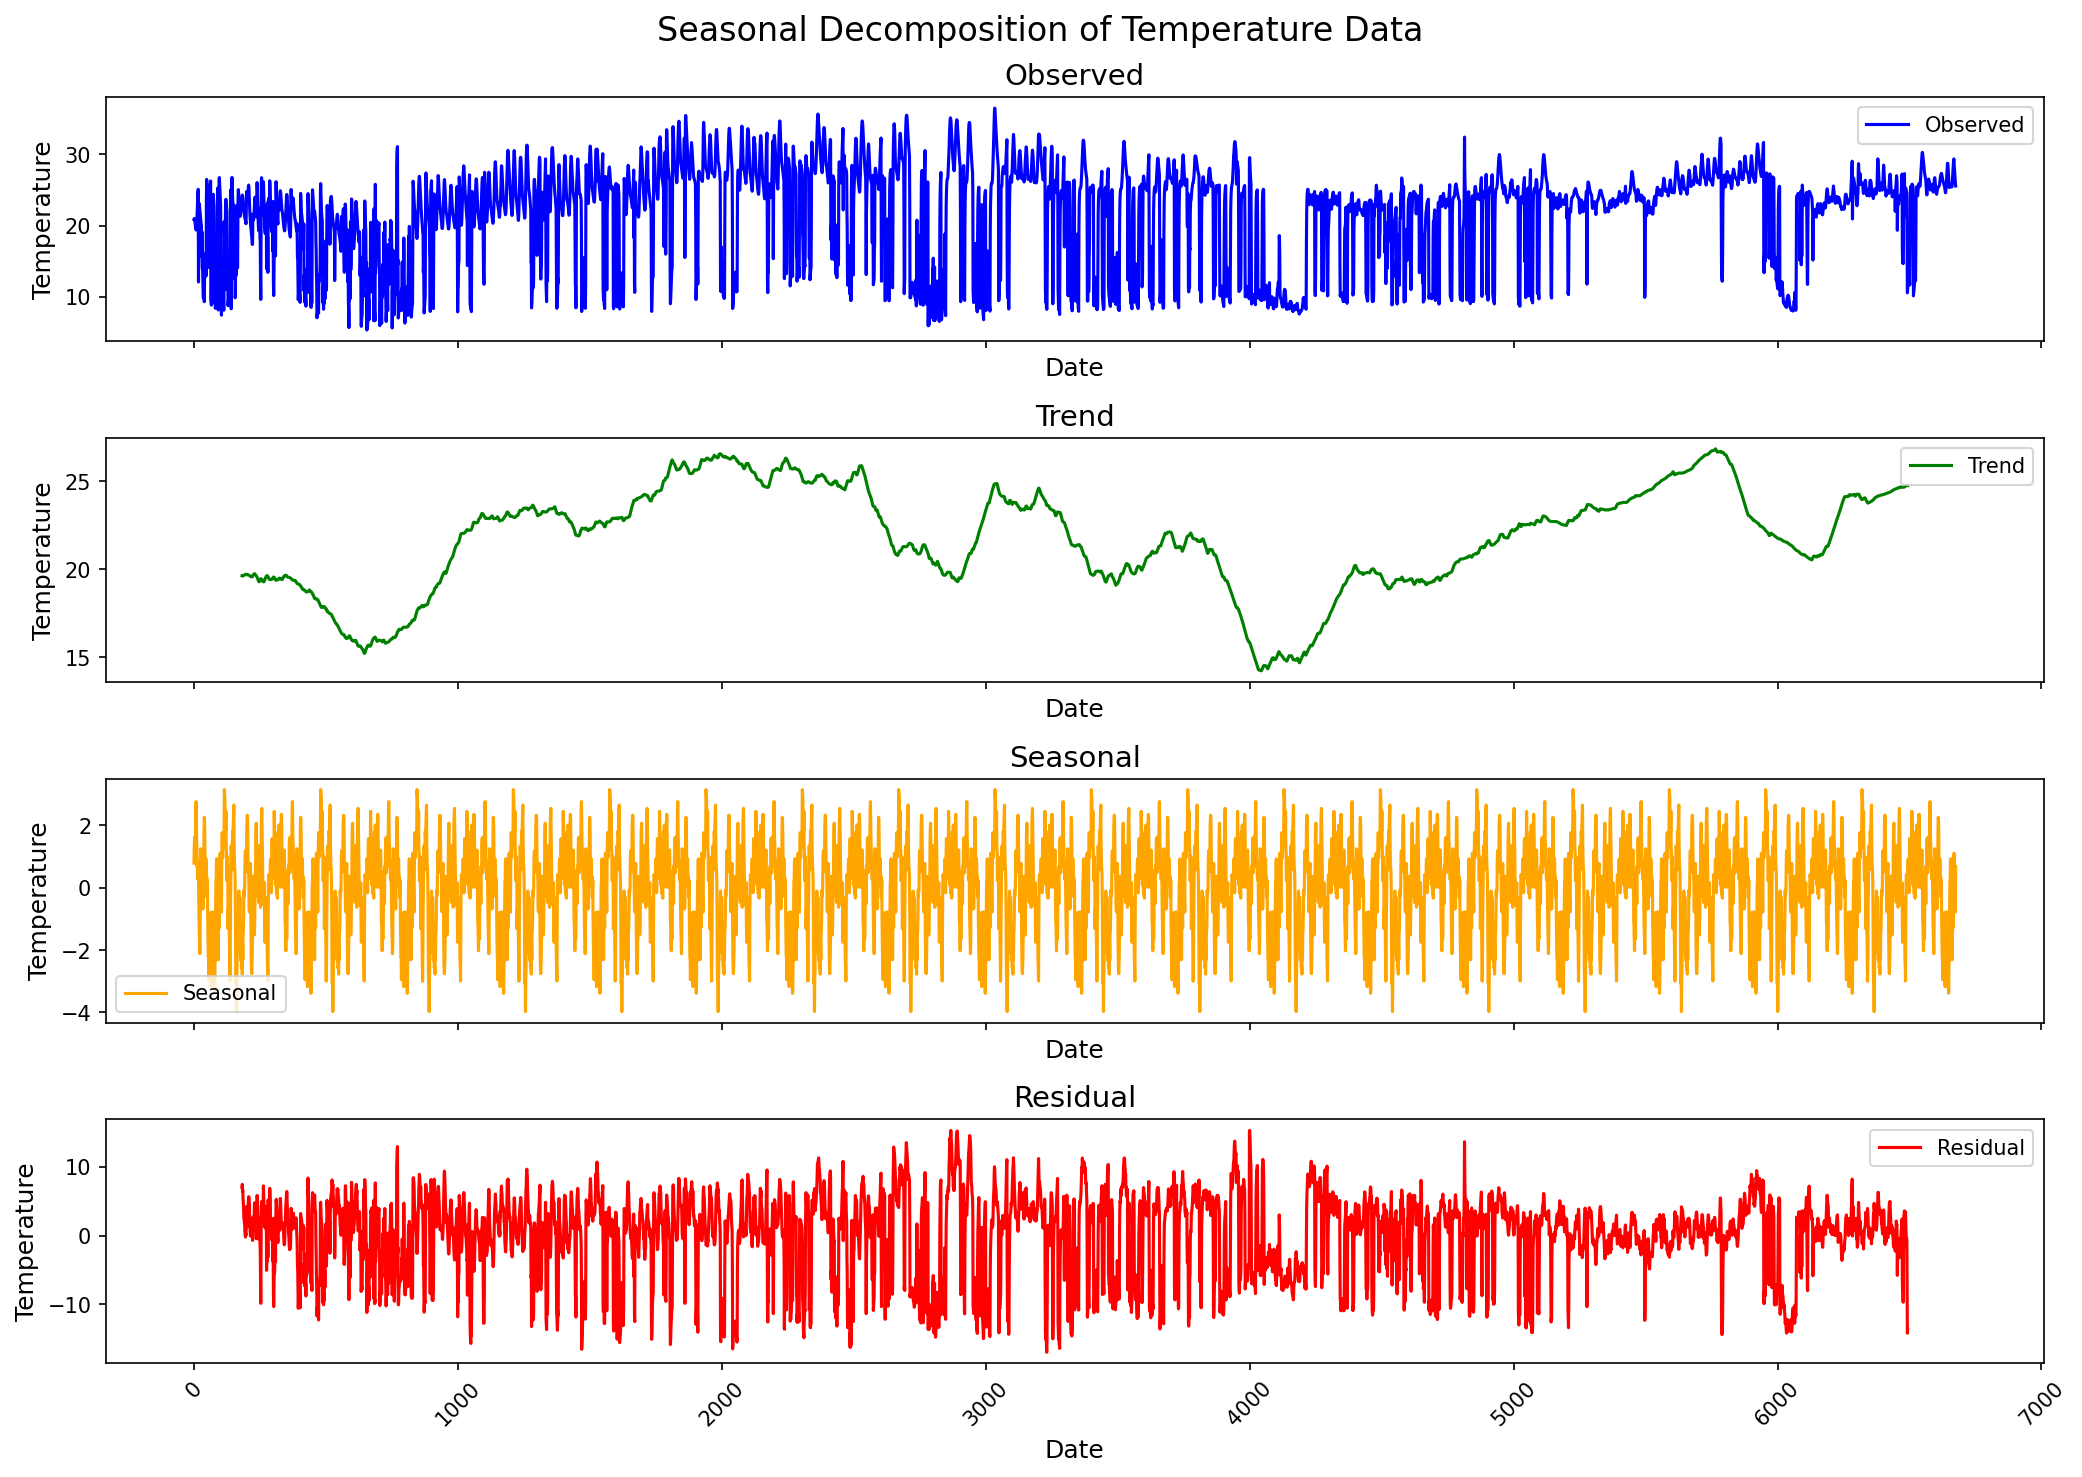

In [306]:
# Seasonal decomposition plot
seasonal_plot = seasonal_decompose(df['DAYTON_MW'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), dpi=150, sharex=True)

# Plot each component
axes[0].plot(seasonal_plot.observed, label='Observed', color='blue')
axes[0].set_title('Observed', fontsize=14)
axes[0].legend(loc='best')

axes[1].plot(seasonal_plot.trend, label='Trend', color='green')
axes[1].set_title('Trend', fontsize=14)
axes[1].legend(loc='best')

axes[2].plot(seasonal_plot.seasonal, label='Seasonal', color='orange')
axes[2].set_title('Seasonal', fontsize=14)
axes[2].legend(loc='best')

axes[3].plot(seasonal_plot.resid, label='Residual', color='red')
axes[3].set_title('Residual', fontsize=14)
axes[3].legend(loc='best')

# Set common labels and rotate x-axis labels
for ax in axes:
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Temperature', fontsize=12)
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

plt.suptitle('Seasonal Decomposition of Temperature Data', fontsize=16)
plt.tight_layout()  # Automatically adjust subplot parameters
plt.show()

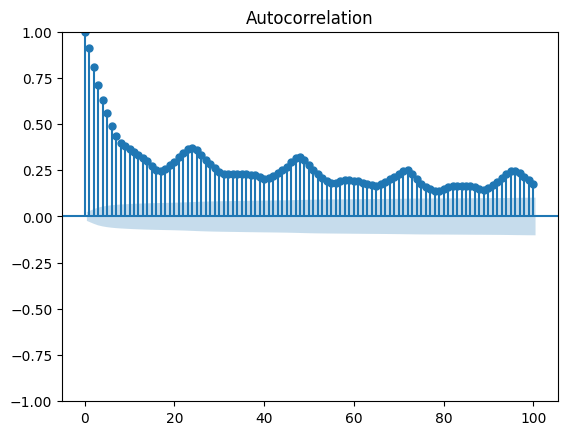

In [307]:
# Plot a autocorrelation plot
plot_acf(df['DAYTON_MW'],lags=100)
plt.show()

In [308]:
# Split the data into 80-20
split_index = int(len(df_prophet) * 0.8)
train = df_prophet[:split_index]
test = df_prophet[split_index:]

# train = train.reset_index()
# test = test.reset_index()

In [309]:
# Initialize the Prophet model
m = Prophet(yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = True)

# Fit the model on the training data
m.fit(train)

09:42:16 - cmdstanpy - INFO - Chain [1] start processing
09:42:17 - cmdstanpy - INFO - Chain [1] done processing


In [310]:
# Create a future DataFrame including the test period
future = m.make_future_dataframe(periods=len(test), freq='h')

# Make predictions
forecast = m.predict(future)

In [311]:
# Extract relevant columns for plotting
forecast_plot = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print(forecast_plot.head())  # Print the first few rows for verification

                   ds       yhat  yhat_lower  yhat_upper
0 2022-01-04 00:00:00  17.464366    9.095438   25.258832
1 2022-01-04 01:00:00  17.033359    9.448149   24.999357
2 2022-01-04 02:00:00  16.831243    8.997134   25.356523
3 2022-01-04 03:00:00  16.770756    8.478762   24.836605
4 2022-01-04 04:00:00  16.714081    9.010766   24.105353


In [312]:
# Extract relevant columns from forecast for evaluation
forecast_eval = forecast[['ds', 'yhat']]
forecast_eval = forecast_eval.set_index('ds')

# Ensure the 'test' DataFrame uses 'ds' as the index
test = test.set_index('ds')

# Merge forecast and test data
merged = forecast_eval.join(test)

# Drop rows with NaN values (if any)
merged = merged.dropna()

In [313]:
# Print merged DataFrame columns and head for verification
print("Merged DataFrame columns:", merged.columns)
print(merged.head())

Merged DataFrame columns: Index(['yhat', 'y'], dtype='object')
                          yhat       y
ds                                    
2022-08-14 12:00:00  22.692658  23.700
2022-08-14 13:00:00  22.704436  23.633
2022-08-14 14:00:00  22.918011  23.467
2022-08-14 15:00:00  23.225699  23.200
2022-08-14 16:00:00  23.466843  23.150


In [314]:
 # Print the first 10 rows for a quick look
print("Sample of Real vs. Predicted Values:")
print(merged.head(5))
print(merged.tail(5))

Sample of Real vs. Predicted Values:
                          yhat       y
ds                                    
2022-08-14 12:00:00  22.692658  23.700
2022-08-14 13:00:00  22.704436  23.633
2022-08-14 14:00:00  22.918011  23.467
2022-08-14 15:00:00  23.225699  23.200
2022-08-14 16:00:00  23.466843  23.150
                          yhat       y
ds                                    
2022-10-08 23:00:00  25.436856  27.350
2022-10-09 00:00:00  24.636932  26.800
2022-10-09 01:00:00  23.955405  26.450
2022-10-09 02:00:00  23.506827  25.900
2022-10-09 03:00:00  23.205381  25.567


In [325]:
# Calculate and print evaluation metrics
mae = mean_absolute_error(df_prophet['y'], forecast_eval['yhat'])
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(df_prophet['y'], forecast_eval['yhat'])
print(f'Mean Squared Error (MSE): {mse}')

r2 = r2_score(df_prophet['y'], forecast_eval['yhat'])
print(f'R-squared (R²): {r2}')

Mean Absolute Error (MAE): 4.871110590986029
Mean Squared Error (MSE): 36.82865079704855
R-squared (R²): 0.21511483151792188


In [321]:
# Calculate and print evaluation metrics
mae = mean_absolute_error(merged['y'], merged['yhat'])
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(merged['y'], merged['yhat'])
print(f'Mean Squared Error (MSE): {mse}')

r2 = r2_score(merged['y'], merged['yhat'])
print(f'R-squared (R²): {r2}')

Mean Absolute Error (MAE): 3.669051443438447
Mean Squared Error (MSE): 23.84047234400425
R-squared (R²): -0.13686070864160516


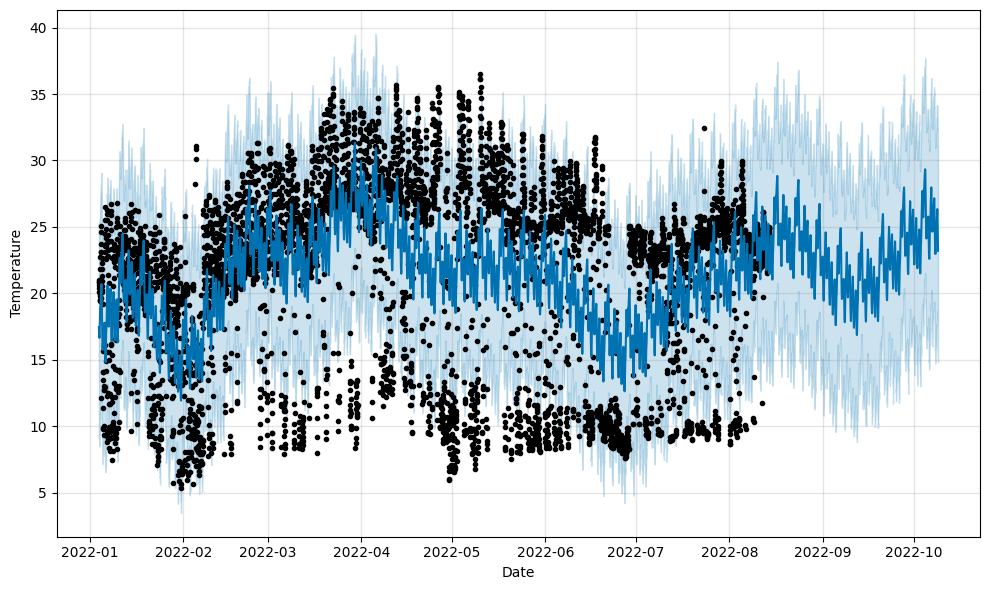

In [316]:
# Plot the forecast with the full forecast DataFrame
fig1 = m.plot(forecast)
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.show()

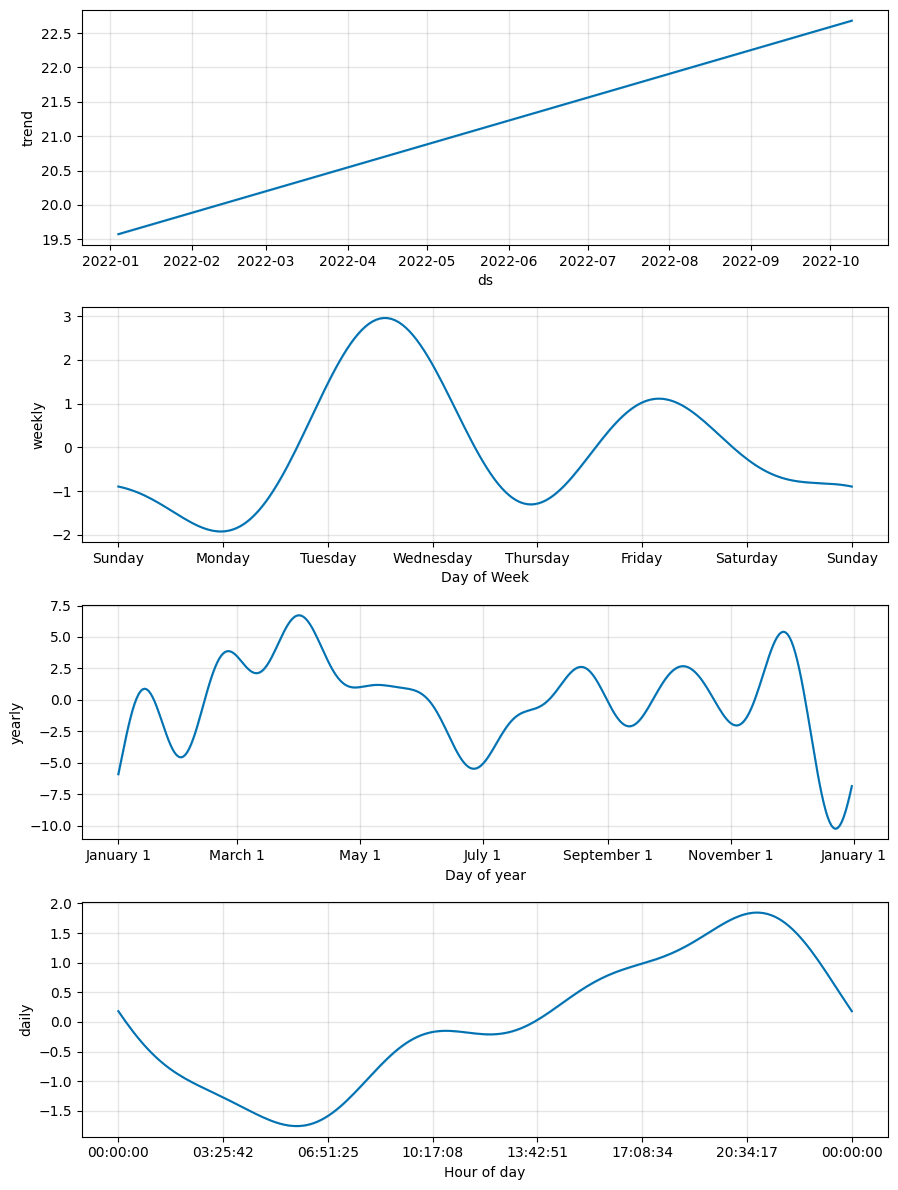

In [317]:
# Plot components of the forecast
fig2 = m.plot_components(forecast)
plt.show()

In [318]:
result = df_prophet[['y']].join(forecast[['yhat']], how='left')

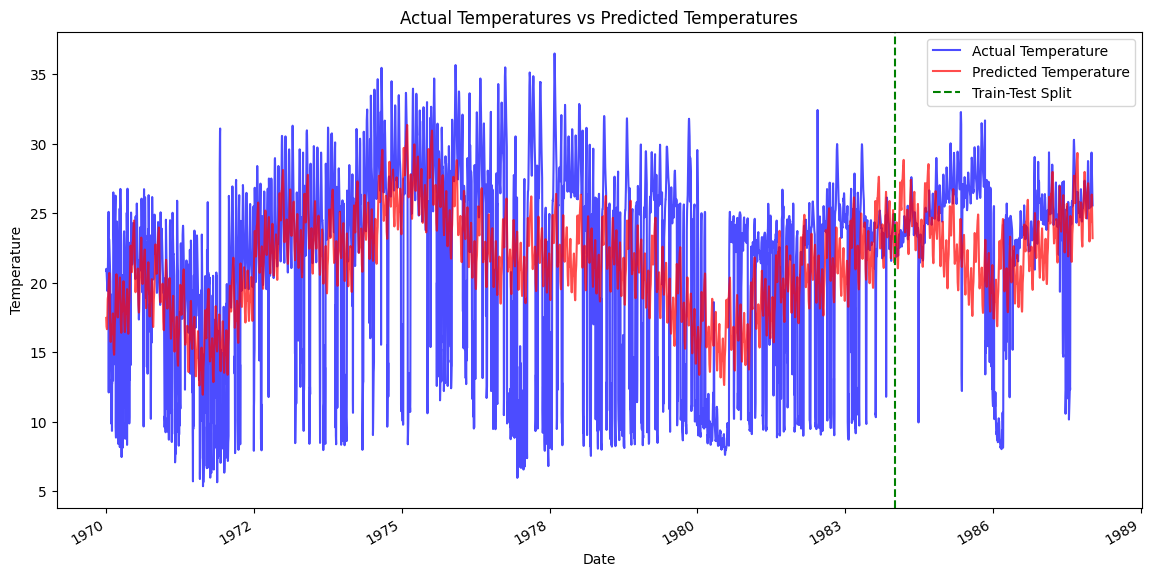

In [319]:
# Plot a graph to show actual temperatures vs predicted temperatures
plt.figure(figsize=(14, 7))
plt.plot(result.index, result['y'], label='Actual Temperature', color='blue', alpha=0.7)
plt.plot(result.index, result['yhat'], label='Predicted Temperature', color='red', alpha=0.7)
plt.axvline(x=train.index[-1], color='green', linestyle='--', label='Train-Test Split')
plt.title('Actual Temperatures vs Predicted Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.show()